## Task 1
### Explore the differences in visas issued in NYC and SF Bay Area

Since this data is actually the LCA application data, we can't exactly explore the number of issued visas but we can explore the number of potential visas by looking at the trends in successful LCA applications.

### Description of data cleaning

The exact method can be seen in the other notebooks but I will briefly describe the motivation for and results of my approach to getting the data for this task:

1. I kept only those data where the LCA was certified and not withdrawn, since those were the only cases which could have become visas
2. Since this dataset is supposed to be for H1B visas issued in 2014, I kept only those data where the LCA was submitted within 6 months of 2014. It is a condition that LCA is submitted within this timeframe, as outlined here: https://www.foreignlaborcert.doleta.gov/h-1b.cfm Similarly, I removed any rows for LCA that had a start date any later than the last day in 2014.
4. For the sake of salary comparison, I removed any applications for part time work, since there is no reliable way to compare without knowing the hours worked. This was a very small part of the dataset.
5. For the remaining pay information, I transformed everything in the wage_rate_from, wage_rate_to, pw_1, and pw_2 columns into an annual salary for easy comparison. I did this by assuming that "Monthly" rate could be converted to annual with a factor of 12, Bi-Weekly with a factor of 26, and Hourly with a factor of 52 weeks by 40 hours.
6. Since a lot of the text data was misspelled and otherwise messy, I did my best to find unique matches of things like company names, addresses, SOC codes, etc. by fuzzy-matching and comparing with outside reliable data sources from the census bureau and ONET, removing codes and addresses that don't make sense or cross-referencing to figure out which codes to replace them with.
7. For the NYC and SF data, I got neighbourhood and county/place name data from the NYC and SF open data webpages, in order to make sure I could distinguish work locations within the metropolitan areas from other areas in the states of NY and CA.

In [1]:
# first let's just import some modules
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

/home/kilian/.envs/elucd/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# load in the two dataframes for NYC and SF which I have cleaned up
nycdf = pd.read_csv("../dat/nycdf.csv")
sfdf = pd.read_csv("../dat/sfdf.csv")

###  How many visas could be issued for NYC and SF

Here I'll just sum over the "total_workers" column for the NYC and SF dataframes of cleaned up data, counting the number of visas for each company for each job that were applied for with LCAs

In [4]:
nycnum = nycdf.total_workers.sum()
nycnum

61139.0

In [5]:
sfnum = sfdf.total_workers.sum()
sfnum

111004.0

### Do the number of visas issued in NYC differ in any meaningful way from those issued in SF?

Clearly, the number in SF is larger than the number in NYC. But just to be sure, I will compute the rate of visas in the population for each metro area. The numbers were found on google/wikipedia and come from the census webpages for each area

In [6]:
nycpop = 8472000
sfpop = 7150739 + (7684011 - 7150739) * (4/6)

In [7]:
nyc_visarate = nycdf.total_workers.sum() / nycpop
nyc_visarate

0.0072165958451369215

In [9]:
sf_visarate = sfdf.total_workers.sum() / sfpop
sf_visarate

0.01478820260137758

Since the populations are very similar, we see that the Bay Area has double the rate of visas as New York City. I find it really surprising that more than 1 in every 100 people in the Bay Area was getting a H1B in 2014!

And just to make sure this is not somehow skewed by people whose secondary work locations are in these areas, I'll make the count only for primary workplaces:

In [74]:
nycprim = nycdf.loc[nycdf.lca_case_workloc1_state == "NY", :]
sfprim = sfdf.loc[sfdf.lca_case_workloc1_state == "CA", :]
print(nycprim["total_workers"].sum())
print(sfprim["total_workers"].sum())

56861.0
106471.0


There's a similar rate of Secondary workers in both areas, so still about a factor of 2 difference.

### Hypothesis No. 1

Here, I'm going to go with a pretty obvious approach, for anyone that has paid attention to the internet or current affairs in general over the last while. Let's see if the difference in the demand for H1Bs is driven by labour demand in a particular kind of job category which might happen to be represented more in the Bay Area than in NYC.

I think an interesting test to use to decide whether something like this is at play would be Fisher's exact test. This takes a 2x2 contingency table of samples which can be classified in two different classes of binary categories. The test then determines the probability of drawing these samples from the same class-association. This would be an appropriate null hypothesis in our case: taking two separate job categories, is the proportion of jobs in NYC versus SF the same in both categories. If the proportions across all pairs of job categories are the same, then we cannot rule out the null hypothesis - i.e. there is no particular job type which explains the difference in visa numbers between SF and NYC. Otherwise, our data lend support to the alternative hypothesis, which is that there is a lot more demand in the Bay Area for particular jobs.

I'll perform the test then across all pairs and compare p values between pairs of job categories. I'm restricting the job category to only the 20 highest level categories, which come from the first two digits in the SOC numbers.

In [4]:
# First add the two dataframes together, removing any rows where there are
# no SOC codes (very few) and adding a metro area label
nycdf["metro"] = "NYC"
sfdf["metro"] = "SF"
socdf = pd.concat([nycdf, sfdf]).dropna(subset=["lca_case_soc_code"])

# add a column with job category that only uses first two digits of soc code
socdf["jobcat"] = [soc[:2] for soc in socdf.lca_case_soc_code]

In [58]:
# count up the total number of workers in each job category for each metro area
socdf = socdf.groupby(["jobcat", "metro"])["total_workers"].sum().reset_index()

In [59]:
# here's our resulting data table
socdf

,jobcat,metro,total_workers
0,11,NYC,3536.0
1,11,SF,4482.0
2,13,NYC,18170.0
3,13,SF,11073.0
4,15,NYC,27694.0
5,15,SF,79158.0
6,17,NYC,997.0
7,17,SF,11826.0
8,19,NYC,1062.0
9,19,SF,1116.0


In [61]:
# let me just drop the rows where a job category is not shared in both metro areas
# these are both in single digits anyway
socdf = socdf.drop(socdf.index[[22, 35]])

In [65]:
# here's an example of one pair computation, of a pair that are quite close in proportions between the cities
oddsr, pval = stats.fisher_exact([[int(socdf.iloc[0].total_workers), int(socdf.iloc[1].total_workers)],
                                  [int(socdf.iloc[8].total_workers), int(socdf.iloc[9].total_workers)]])

In [66]:
oddsr

0.82904877513821762

In [67]:
# so they are quite likely to be from distinct distributions, even in the similar jobs
# the Fisher test is very exact, using the hypergeometric function, so I would expect this
# but we can probably still see an interesting trend to support the hypothesis
pval

0.00011271734407661523

In [121]:
# now to compute over all pairs and store in a matrix
ncats = socdf.jobcat.nunique()
pmat = np.zeros((ncats, ncats))

for i in range(ncats - 1):
    for j in range(i + 1, ncats - 1):
        oddsr, pval = stats.fisher_exact([[int(socdf.iloc[2 * i].total_workers), int(socdf.iloc[2 * i + 1].total_workers)],
                                          [int(socdf.iloc[2 * j].total_workers), int(socdf.iloc[2 * j + 1].total_workers)]])
        
        # here I convert the resulting p value to a "score" by taking the negative log
        if pval > 0:
            pmat[i, j] = -np.log10(pval)
        # if the pvalue is so small that it is zero in machine precision, I assign a greater score than the others
        else:
            pmat[i, j] = 350

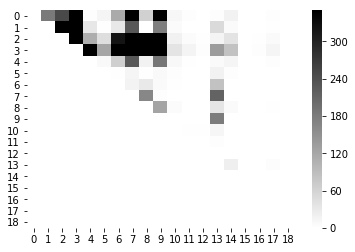

In [122]:
# we can see the results in a heatmap
sns.heatmap(pmat, cmap=plt.get_cmap("binary"))

Here it's clear that the first four occupations are from very different populations between the two metropolitan areas, particularly the third and fourth job categories. It's no surprise to see what these correspond to, from the Bureau of Labour Statistics https://www.bls.gov/oes/current/oes_stru.htm

- 15 = Computer and Mathematical Occupations
- 17 = Architecture and Engineering Occupations

It's also easy to see this trend without any kind of statistical test, by just looking at the numbers per job category compared against each other, where we can see computer and engineering jobs are in massively higher demand in SF:

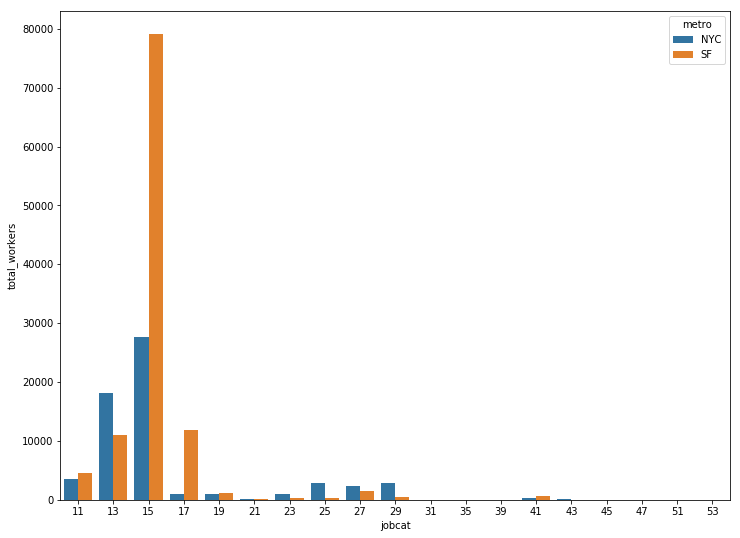

In [124]:
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111)
sns.barplot(x="jobcat", y="total_workers", hue="metro",
            data=socdf,
            ax=ax)

### Hypothesis No. 2

So at least a good chunk of the difference in demand for H1B workers is driven by need for people in certain classes of job function. The difference in the computer/maths occupation numbers is alone sufficient to explain the 50k difference in NYC and SF numbers. But now I wonder if this is a general trend in the Bay Area in general that results in this higher demand? Or is there maybe a set of companies which are driving it. Is the average company in NYC and SF more or less the same in terms of how many employees they need and there are just a few companies in particular which are hiring a lot more?

Taking a look at a violin plot version of the last graph, where we see the distribution of workers sought per company within the different job categories suggests this may be so:

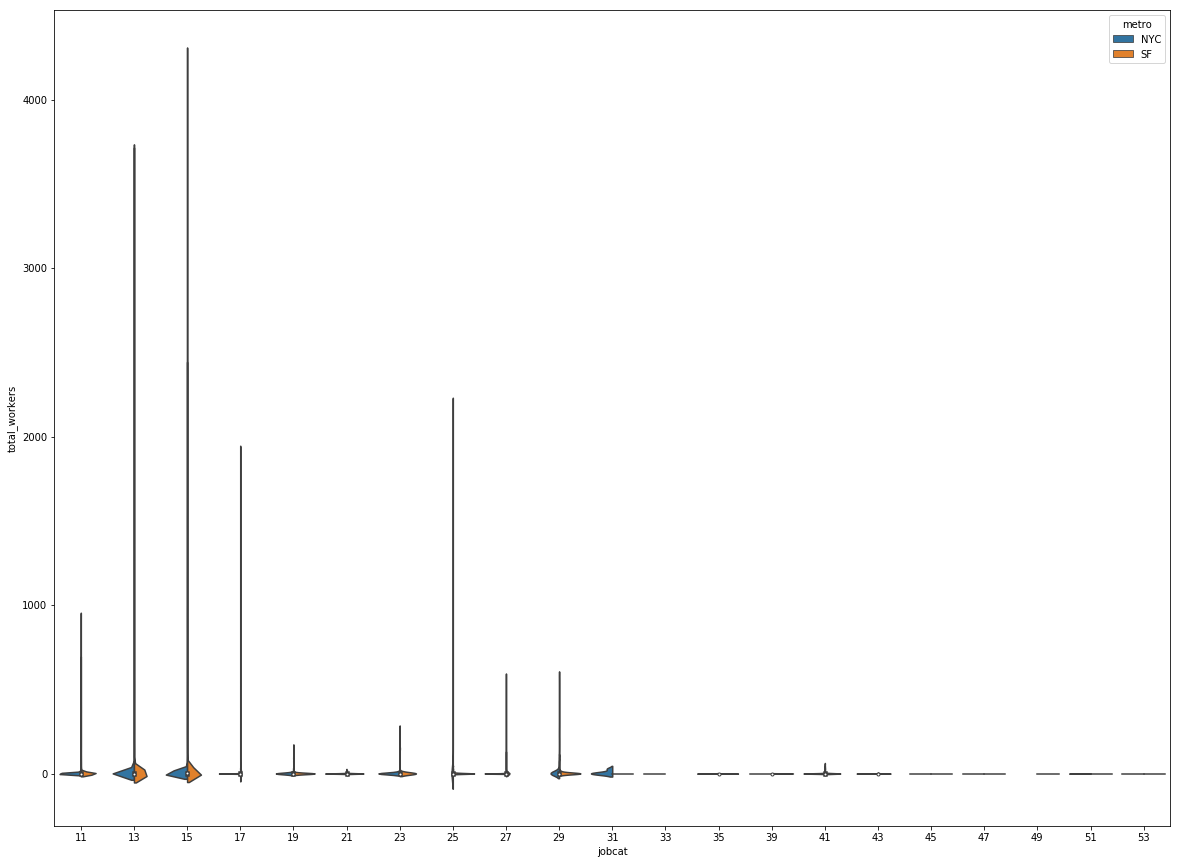

In [77]:
empdf = pd.concat([nycdf, sfdf]).dropna(subset=["lca_case_soc_code"])
empdf["jobcat"] = [soc[:2] for soc in empdf.lca_case_soc_code]
empdf = empdf.groupby(["metro", "jobcat", "lca_case_employer_name"])["total_workers"].sum().reset_index()

fig = plt.figure(figsize=(20,15))
sns.violinplot(x="jobcat", y="total_workers", hue="metro", data=empdf, split=True)

(0, 200)

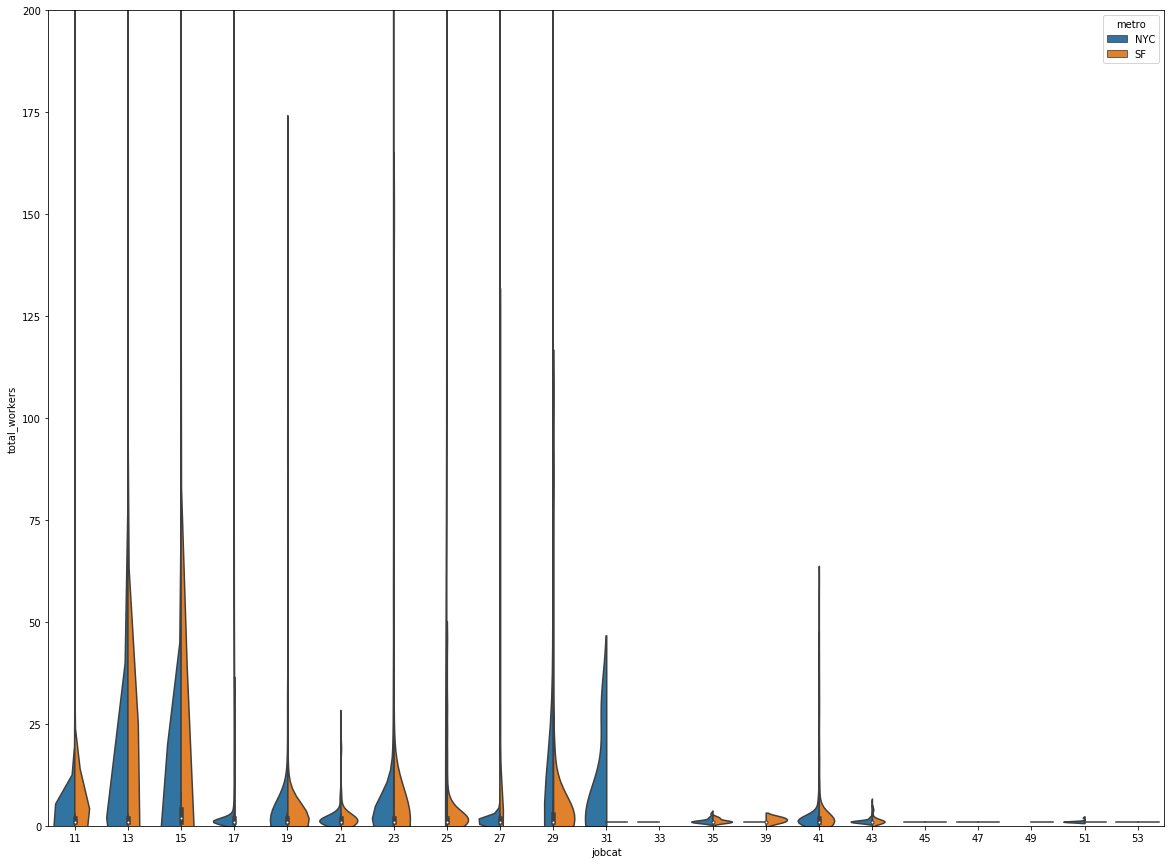

In [78]:
# zooming in a little on the bean plot...
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111)
sns.violinplot(x="jobcat", y="total_workers", hue="metro", data=empdf, split=True)
ax.set_ylim([0,200])

To test the similarity of the distributions of worker demand per company in a particular job category, I will use the Kolmogorov-Smirnov test. This basically takes a distance metric for comparing the cumulative distribution functions of two random variables and tests whether the variables were drawn from the same distribution. So if my hypothesis is correct, I expect that if I run this test on samples from NYC and SF of the workers demanded by different companies, excluding numbers higher than some value, that there will not be a significant difference in the distributions.

As a crude first approach, let's take a look at the CDFs together, first for the Computer/Maths occupations:

In [79]:
nycomp = empdf.loc[np.logical_and(empdf.metro == "NYC", empdf.jobcat == "15"), ["total_workers"]].values.flatten()
sfcomp = empdf.loc[np.logical_and(empdf.metro == "SF", empdf.jobcat == "15"), ["total_workers"]].values.flatten()

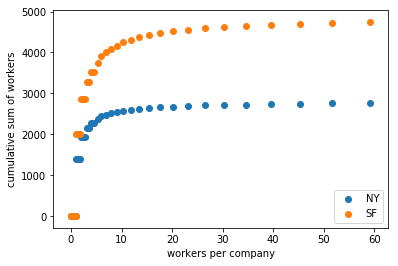

In [80]:
binedges = np.logspace(-1, 1.8, 49)
nyhist = np.histogram(nycomp, bins=binedges)  # , normed=True)
sfhist = np.histogram(sfcomp, bins=binedges)  # , normed=True)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(0.5 * (nyhist[1][:-1] + nyhist[1][1:]), np.cumsum(nyhist[0]), label="NY")
ax.scatter(0.5 * (sfhist[1][:-1] + sfhist[1][1:]), np.cumsum(sfhist[0]), label="SF")

ax.set_xlabel("workers per company")
ax.set_ylabel("cumulative sum of workers")

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc=4)

It looks like they diverge really very early on, so it's pretty clearly not the case that only some companies in the tails are contributing to the big difference in worker demand in software... Though the median values are very small so we'll see better by looking much closer. Oh well, let's run the K-S test anyway just to show that it confirms this. Let's make an exploratory plot for category 17 too, this time a Q-Q plot:

Text(0,0.5,'SF quantiles')

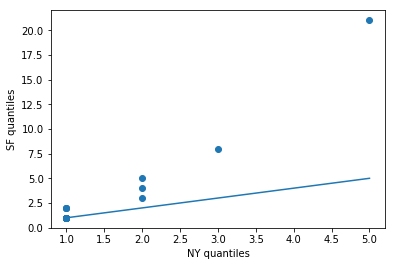

In [81]:
nyeng = empdf.loc[np.logical_and(empdf.metro == "NYC", empdf.jobcat == "17"), ["total_workers"]].values.flatten()
sfeng = empdf.loc[np.logical_and(empdf.metro == "SF", empdf.jobcat == "17"), ["total_workers"]].values.flatten()

nyqs = [np.percentile(nyeng, a) for a in range(5,100,5)]
sfqs = [np.percentile(sfeng, a) for a in range(5,100,5)]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(nyqs, sfqs)
ax.plot(nyqs, nyqs)

ax.set_xlabel("NY quantiles")
ax.set_ylabel("SF quantiles")

The engineering job distributions pretty rapidly as well, at least for the last half of the quantiles. So our K-S tests should tell a similar story here too

In [82]:
# performing K-S test for a range of missing upper quantiles
quantiles = [a for a in range(5, 100, 5)]

kscomp = []
for q in quantiles:
    kscomp.append(stats.ks_2samp(nycomp[np.where(nycomp <= np.percentile(nycomp, q))],
                                 sfcomp[np.where(sfcomp <= np.percentile(sfcomp, q))]))
    
kseng = []
for q in quantiles:
    kseng.append(stats.ks_2samp(nyeng[np.where(nyeng <= np.percentile(nyeng, q))],
                                 sfeng[np.where(sfeng <= np.percentile(sfeng, q))]))

In [83]:
# I'll transform the p-values to a score again to make visualisation easier
kscomp = np.abs(np.log10([ks.pvalue for ks in kscomp]))
kseng = np.abs(np.log10([ks.pvalue for ks in kseng]))

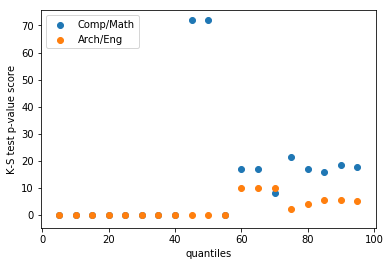

In [84]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(quantiles, kscomp, label="Comp/Math")
ax.scatter(quantiles, kseng, label="Arch/Eng")

ax.set_xlabel("quantiles")
ax.set_ylabel("K-S test p-value score")

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc=2)

So here we see that the K-S test shows the distributions to actually be indistinguishably similar up to around the median, before diverging very quickly to levels where the null hypothesis must be rejected - the smaller non-zero scores still represent p-values of ~10e-10. This makes more sense when we see what the median values of the distributions are:

In [85]:
print(np.median(nycomp), np.median(sfcomp))
print(np.median(nyeng), np.median(sfeng))

1.0 2.0
1.0 1.0


So since we are dealing with counts, with a median of order unity, the K-S test turns out to not be such a good idea actually. I think what we can infer from the plots and tests is that, while the vast majority of firms in both places are indeed only applying for very small numbers of workers, the firms who apply for more than one worker in SF are applying for larger numbers than those firms that are applying for more in NY. For computer/maths jobs in SF, companies are more likely to be hiring more than one worker and the rate grows very rapidly thereafter as compared with NY.

### Hypothesis No. 3

One interesting feature of the data to look into is the prevailing wage for a particular job in a particular area. Companies are required to provide this in the LCA so that the Department of Labor will know whether the H1B visa process is being taken advantage of to hire lower wage foreign workers and take advantage of their vulnerability by paying them less than their american counterparts. This suggests that one reason why companies may choose to hire more workers in a given region compared with another is because they may be able to pay less for the same work in that region since they can provide evidence for lower prevailing wages.

While it seems intuitively unlikely that SF has lower wages than NY, I think this is still interesting to investigate. The prevailing wage is defined in the data by surveys provided with the LCA, so whether or not the wages are indeed lower, there may be surveys which can show the DOL that they are and thus allow companies in SF to hire workers at a lower cost than they could if they were in NY, where surveys may be more accurate.

To investigate this hypothesis, I will perform a regression for the number of workers that are hired, as a function of prevailing wages in the area, while controlling for job category and metro area. I'll do this just for people who are in the areas as their primary workplace, so as not to complicate the calculation. This seems reasonable, as I doubt companies are hiring multi-location workers on grounds of there being favourable work rates in NYC and SF.

First let's take a look at the data, where I am only including the most common job categories, to be sure I have enough statistical power for each of the variables:

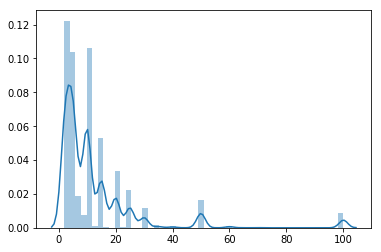

In [161]:
regdf = pd.concat([nycprim, sfprim]).dropna(subset=["lca_case_soc_code", "lca_case_soc_code", "total_workers"])
regdf["jobcat"] = [soc[:2] for soc in regdf.lca_case_soc_code]
regdf = regdf.loc[regdf.jobcat.isin(["11", "13", "15", "17"]), :]

# sns.distplot(np.exp(regdf.total_workers.dropna()).values.flatten())
sns.distplot(regdf.loc[regdf.total_workers > 1, ["total_workers"]].dropna().values.flatten())

Here we can see that the total_worker outcome counts are not following a regular Poisson distribution but overdispersed. The variance is much greater than the mean so we will be best off using a more general/flexible model for the regression, like a negative binomial.

In [162]:
regdf.total_workers.describe()

count    71715.000000
mean         2.067963
std          5.817965
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max        100.000000
Name: total_workers, dtype: float64

here I just set up the design matrix for the regression, one-hot encoding the categorical variables appropriately, and standardising the prevailing wages data so that it is in the ones rather than the hundreds of thousands

In [163]:
# make dummy columns for the categorical variables
jobcatdf = pd.get_dummies(regdf["jobcat"], prefix="jobcat")
metrodf = pd.get_dummies(regdf["metro"])

# I'll standardise the prevailing wages data, so it's closer in magnitude to what we're looking for
normpw = (regdf.pw_1 - regdf.pw_1.mean()) / (regdf.pw_1.max() - regdf.pw_1.min())

# drop one of the category columns to remove redundancy
depvars = pd.concat([metrodf.drop(columns="NYC"), jobcatdf.drop(columns=["jobcat_17"]), normpw], axis=1)
depvars.pw_1.describe()

count    7.171500e+04
mean    -2.377888e-18
std      7.353291e-02
min     -2.050845e-01
25%     -5.601261e-02
50%     -1.327388e-02
75%      4.142014e-02
max      7.949155e-01
Name: pw_1, dtype: float64

In [164]:
# add a constant factor for regression
X = sm.add_constant(depvars)
X.describe()

,const,SF,jobcat_11,jobcat_13,jobcat_15,pw_1
count,71715.0,71715.000000,71715.000000,71715.000000,71715.000000,7.171500e+04
mean,1.0,0.669665,0.058412,0.155728,0.711093,-2.377888e-18
std,0.0,0.470337,0.234522,0.362599,0.453258,7.353291e-02
min,1.0,0.000000,0.000000,0.000000,0.000000,-2.050845e-01
25%,1.0,0.000000,0.000000,0.000000,0.000000,-5.601261e-02
50%,1.0,1.000000,0.000000,0.000000,1.000000,-1.327388e-02
75%,1.0,1.000000,0.000000,0.000000,1.000000,4.142014e-02
max,1.0,1.000000,1.000000,1.000000,1.000000,7.949155e-01


taking a quick look at the covariance of the dependent variables, we can see that computer/maths jobs show some correlation with prevailing wages, which is not unexpected:

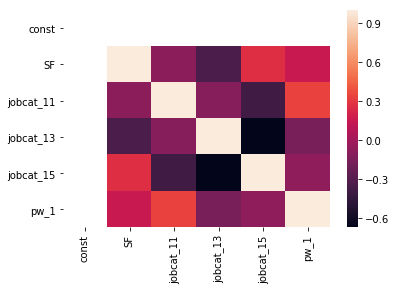

In [165]:
sns.heatmap(X.corr())

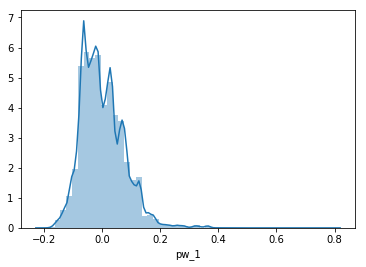

In [166]:
sns.distplot(depvars.pw_1)

Here I'll run a Poisson regression just for comparison:

In [169]:
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)  # workaround for a statsmodel error
model = sm.Poisson(regdf.total_workers, X).fit(method="nm")
model.summary()

/home/kilian/.envs/elucd/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:          total_workers   No. Observations:                71715
Model:                        Poisson   Df Residuals:                    71709
Method:                           MLE   Df Model:                            5
Date:                Sat, 02 Dec 2017   Pseudo R-squ.:                 -0.1141
Time:                        00:27:39   Log-Likelihood:            -2.4630e+05
converged:                      False   LL-Null:                   -2.2107e+05
                                        LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0480      0.015      3.228      0.001       0.019       0.077
SF             0.0263      0.008      3.159      0.002       0.010       0.043
jobcat_11      0.0096      0.021      0.464      0.643      -0.031       0.050
jobcat_13     -0.0288      0.017     -1.714      0.086      -0.062       0.004
jobcat_15      0.0321      0.014      2.316      0.021       0.005       0.059
pw_1          -0.0135      0.053     -0.254      0.799      -0.118       0.091
==============================================================================
"""

And here's the negative binomial regression

In [168]:
model = sm.NegativeBinomial(regdf.total_workers, X, loglike_method='nb2').fit(method='nm')
model.summary()

/home/kilian/.envs/elucd/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                     NegativeBinomial Regression Results                      
==============================================================================
Dep. Variable:          total_workers   No. Observations:                71715
Model:               NegativeBinomial   Df Residuals:                    71709
Method:                           MLE   Df Model:                            5
Date:                Sat, 02 Dec 2017   Pseudo R-squ.:                0.001872
Time:                        00:27:03   Log-Likelihood:            -1.3846e+05
converged:                      False   LL-Null:                   -1.3872e+05
                                        LLR p-value:                4.920e-110
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8568      0.018     46.568      0.000       0.821       0.893
SF             0.1476      0.010     14.391      0.000       0.128       0.168
jobcat_11     -0.2863      0.026    -11.170      0.000      -0.337      -0.236
jobcat_13      0.1427      0.020      6.986      0.000       0.103       0.183
jobcat_15     -0.2933      0.017    -17.232      0.000      -0.327      -0.260
pw_1          -0.5324      0.069     -7.715      0.000      -0.668      -0.397
alpha          0.9024      0.006    149.768      0.000       0.891       0.914
==============================================================================
"""

And one more shot with a GLM for kicks:

In [167]:
model = sm.GLM(regdf.total_workers, X, family=sm.families.NegativeBinomial()).fit(method='nm')
model.summary()

/home/kilian/.envs/elucd/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          total_workers   No. Observations:                71715
Model:                            GLM   Df Residuals:                    71709
Model Family:        NegativeBinomial   Df Model:                            5
Link Function:                    log   Scale:                    5.0834333518
Method:                            nm   Log-Likelihood:            -1.3853e+05
Date:                Sat, 02 Dec 2017   Deviance:                       54720.
Time:                        00:25:35   Pearson chi2:                 3.65e+05
No. Iterations:                   100                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7363      0.042     17.524      0.000       0.654       0.819
SF             0.1574      0.024      6.616      0.000       0.111       0.204
jobcat_11     -0.1624      0.059     -2.741      0.006      -0.279      -0.046
jobcat_13      0.1111      0.047      2.386      0.017       0.020       0.202
jobcat_15     -0.1835      0.039     -4.717      0.000      -0.260      -0.107
pw_1          -0.3973      0.157     -2.524      0.012      -0.706      -0.089
==============================================================================
"""

Interestingly, according to these models and their significance tests, there does in fact seem to be support for the idea that the total number of workers hired is negatively correlated with the prevailing wages in the region for that job. However, since I have standardised the wage rates to values whose magnitudes are mostly much smaller than unity, the coefficient suggests that the effect is rather small. To quantify the contribution the effect has on the difference in the visa rates in NYC vs SF, I would need to see what the distribution of prevailing wages is among different jobs in each region and see how often they tended to be lower in SF and whether those were cases where more work was demanded. Here's a first glance at what that distribution looks like overall and not a lot can be gleaned from it. Further investigation would require more hypotheses and testing.

Text(0,0.5,'total_workers')

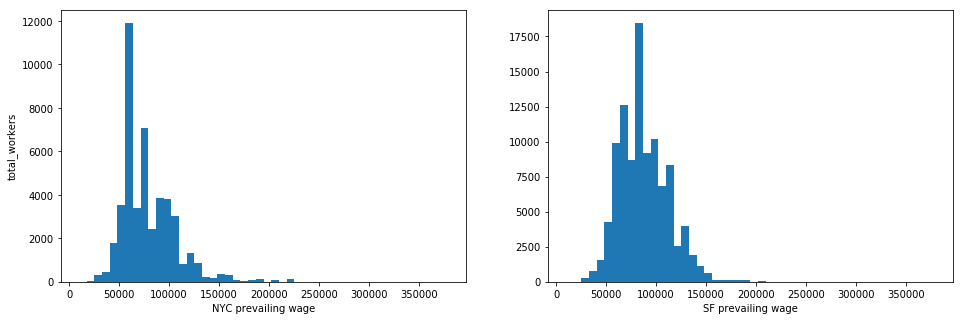

In [172]:
nyreg = regdf.loc[regdf.metro == "NYC", :]
sfreg = regdf.loc[regdf.metro == "SF", :]

pw_bins = np.linspace(regdf.pw_1.min(), regdf.pw_1.max(), 49)

fig = plt.figure(figsize=(16,5))
ax_ny = fig.add_subplot(121)
ax_sf = fig.add_subplot(122)

ax_ny.hist(nyreg.pw_1, bins=pw_bins, weights=nyreg.total_workers)
ax_sf.hist(sfreg.pw_1, bins=pw_bins, weights=sfreg.total_workers)

ax_ny.set_xlabel("NYC prevailing wage")
ax_sf.set_xlabel("SF prevailing wage")
ax_ny.set_ylabel("total_workers")
